In [1]:
# Run this cell to mount your Google Drive.

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Imports

In [2]:
# path
pth = '/content/drive/MyDrive/Colab Notebooks/Thesis'

%cd /content/drive/My Drive/Colab Notebooks/Thesis/SupervisedLearning

from train import *
from visualize_data import *
from utils import *

%cd /content/drive/My Drive/Colab Notebooks/Thesis

/content/drive/My Drive/Colab Notebooks/Thesis/SupervisedLearning
/content/drive/My Drive/Colab Notebooks/Thesis


In [3]:
import torch.nn as nn

class identityEsque(nn.Module):
    '''
    size: 110,110
    '''
    def __init__(self, bias=True):
        super(identityEsque, self).__init__()
        self.l1 = nn.Linear(110, 110, bias=bias)

    def forward(self, features):
        return self.l1(features).to(device)

In [4]:
def plotTrain2(train, val, label, bs, lr):
    plt.figure()
    plt.title("{} vs. Epoch".format(label), fontsize=14)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel(label, fontsize=12)
    plt.plot(train, label='Training {}'.format(label))
    plt.plot(val, label='Validation {}'.format(label))
    plt.yscale('log')
    plt.legend()
    plt.show()
    plt.close()


# Clamping

In [5]:
# https://discuss.pytorch.org/t/set-constraints-on-parameters-or-layers/23620/7
class weightConstraint(object):
    def __init__(self):
        pass
    
    def __call__(self,module):
        if hasattr(module,'weight'):
            # print("Entered")
            w=module.weight.data
            w=w.clamp(-0.5,0.5)
            module.weight.data=w

# Generate Predictions (Inputs/Outputs)

Copied Model: all_states_all_actions_2HL_extra_knock_data_80K

In [ ]:
# state_action pair
state = 'all'
action = 'all'

# model name
model_name = 'all_states_all_actions_2hl_extra_knock_data_80K'

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
state_pth = '{}/models/{}'.format(pth,state)
action_pth = '{}/{}'.format(state_pth,action)
model_pth = '{}/{}'.format(action_pth,model_name)
data_pth = '{}/data/{}/{}'.format(pth,state,action)
model_og = torch.load('{}/model.pt'.format(model_pth), map_location=device)

In [ ]:
numGames = 8000
states = np.load('{}/s_{}k.npy'.format(data_pth, numGames//1000))

In [ ]:
state = np.expand_dims(states, axis=0)
state = torch.from_numpy(state).type(torch.FloatTensor).to(device)
preds = model_og(state)
preds = preds.detach().cpu().numpy().squeeze()
np.save('{}/data/preds.npy'.format(pth), preds)

# Identity Layer + Bias

## Parameters

In [ ]:
# Training parameters
batch_size = 10000
lr = 0.001
epochs = 200
loss='MSE'

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data

In [ ]:
preds = np.load('{}/data/preds.npy'.format(pth))

In [ ]:
data_train, data_val, label_train, label_val = train_test_split(preds, preds, test_size=0.3, random_state=421)
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)

## Approximate Layer

In [ ]:
model = identityEsque().to(device)
loss_fnc = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loss = []
val_loss = []
start_time = time.time()

for epoch in range(epochs):
    accum_loss = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.type(torch.FloatTensor).to(device)
        labels = labels.type(torch.FloatTensor).to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        batch_loss = loss_fnc(input=outputs, target=labels)
        accum_loss += batch_loss
        batch_loss.backward()
        optimizer.step()

        del data

    # evaluate per epoch
    _, vloss = evaluate(model, val_loader, loss_fnc, loss, device)
    val_loss.append(vloss)
    train_loss.append(accum_loss.item()/(i+1))

    # print records
    print("Epoch: {} | Train Loss: {:.20f}"
        .format(epoch + 1, train_loss[epoch]))
    print("              Val Loss: {:.20f}"
        .format(val_loss[epoch]))
    accum_loss = 0.0


print('Finished Training')
end_time = time.time()
elapsed_time = end_time - start_time
print("Total training time elapsed: {:.2f} seconds".format(elapsed_time))

Epoch: 1 | Train Loss: 0.00131542194220754831
              Val Loss: 0.00022072446881793439
Epoch: 2 | Train Loss: 0.00006087535681823889
              Val Loss: 0.00000397969188270508
Epoch: 3 | Train Loss: 0.00000092727845589656
              Val Loss: 0.00000017523235840144
Epoch: 4 | Train Loss: 0.00000016276716350047
              Val Loss: 0.00000016081609999219
Epoch: 5 | Train Loss: 0.00000015766400136070
              Val Loss: 0.00000015817909115867
Epoch: 6 | Train Loss: 0.00000015841184601110
              Val Loss: 0.00000015550328669178
Epoch: 7 | Train Loss: 0.00000015504521242191
              Val Loss: 0.00000015279938736512
Epoch: 8 | Train Loss: 0.00000014636159701493
              Val Loss: 0.00000015037005596241
Epoch: 9 | Train Loss: 0.00000014334249145678
              Val Loss: 0.00000014774258261241
Epoch: 10 | Train Loss: 0.00000013965854527164
              Val Loss: 0.00000014529621239490
Epoch: 11 | Train Loss: 0.00000013660030617757
              Val Loss

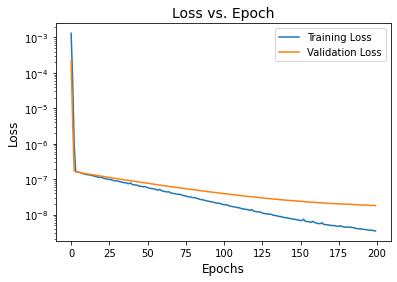

In [ ]:
plotTrain2(train_loss, val_loss, 'Loss', batch_size, lr)

In [ ]:
state_dict = model.state_dict()
torch.save(state_dict, '{}/models/identity/identity_and_bias.pth'.format(pth))

## Distribution

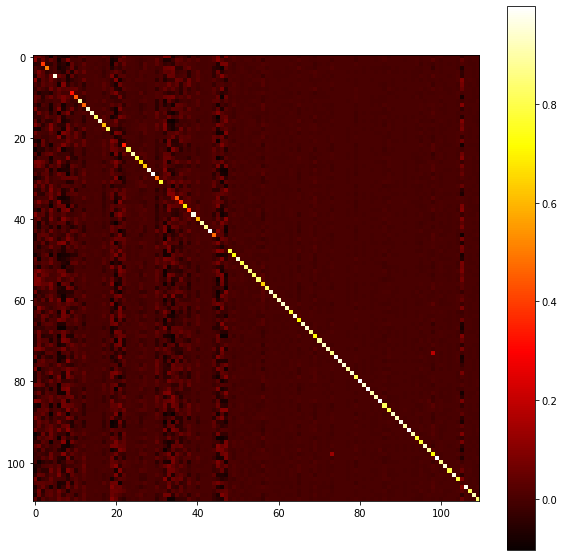

In [9]:
state_dict = torch.load('{}/models/identity/identity_and_bias.pth'.format(pth))
weights = state_dict['l1.weight'].cpu().detach().numpy()
plt.figure(figsize=(10,10))
plt.imshow(weights, cmap='hot')
plt.colorbar()
plt.savefig('{}/plots/identity/identity_and_bias.png'.format(pth))
plt.show()

# Identity Layer, no bias

## Parameters

In [ ]:
# Training parameters
batch_size = 10000
lr = 0.001
epochs = 200
loss='MSE'

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data

In [ ]:
preds = np.load('{}/data/preds.npy'.format(pth))

In [ ]:
data_train, data_val, label_train, label_val = train_test_split(preds, preds, test_size=0.3, random_state=421)
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)

## Approximate Layer

In [ ]:
model = identityEsque(bias=False).to(device)
loss_fnc = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loss = []
val_loss = []
start_time = time.time()

for epoch in range(epochs):
    accum_loss = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.type(torch.FloatTensor).to(device)
        labels = labels.type(torch.FloatTensor).to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        batch_loss = loss_fnc(input=outputs, target=labels)
        accum_loss += batch_loss
        batch_loss.backward()
        optimizer.step()

        del data

    # evaluate per epoch
    _, vloss = evaluate(model, val_loader, loss_fnc, loss, device)
    val_loss.append(vloss)
    train_loss.append(accum_loss.item()/(i+1))

    # print records
    print("Epoch: {} | Train Loss: {:.20f}"
        .format(epoch + 1, train_loss[epoch]))
    print("              Val Loss: {:.20f}"
        .format(val_loss[epoch]))
    accum_loss = 0.0


print('Finished Training')
end_time = time.time()
elapsed_time = end_time - start_time
print("Total training time elapsed: {:.2f} seconds".format(elapsed_time))

Epoch: 1 | Train Loss: 0.00000017172067146021
              Val Loss: 0.00000016870174590622
Epoch: 2 | Train Loss: 0.00000016906866070106
              Val Loss: 0.00000016588674611739
Epoch: 3 | Train Loss: 0.00000016342986934130
              Val Loss: 0.00000016306701411395
Epoch: 4 | Train Loss: 0.00000015949363943138
              Val Loss: 0.00000016003812675081
Epoch: 5 | Train Loss: 0.00000015916551395397
              Val Loss: 0.00000015751297155475
Epoch: 6 | Train Loss: 0.00000015212937240803
              Val Loss: 0.00000015478134685054
Epoch: 7 | Train Loss: 0.00000014831602533781
              Val Loss: 0.00000015205849024369
Epoch: 8 | Train Loss: 0.00000014562509578455
              Val Loss: 0.00000014946529347526
Epoch: 9 | Train Loss: 0.00000014157592431729
              Val Loss: 0.00000014697467065616
Epoch: 10 | Train Loss: 0.00000013823399866750
              Val Loss: 0.00000014450372987085
Epoch: 11 | Train Loss: 0.00000013648054340997
              Val Loss

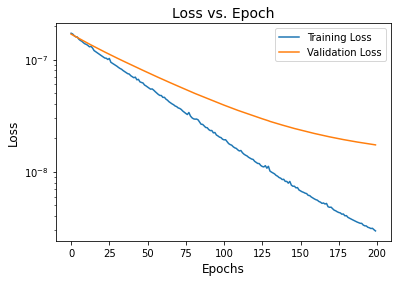

In [ ]:
plotTrain2(train_loss, val_loss, 'Loss', batch_size, lr)

In [ ]:
state_dict = model.state_dict()
torch.save(state_dict, '{}/models/identity_no_bias.pth'.format(pth))

## Distribution

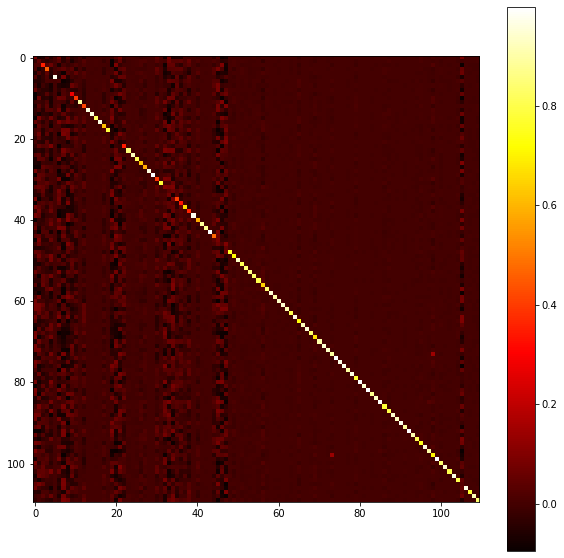

In [10]:
state_dict = torch.load('{}/models/identity/identity_no_bias.pth'.format(pth))
weights = state_dict['l1.weight'].cpu().detach().numpy()
plt.figure(figsize=(10,10))
plt.imshow(weights, cmap='hot')
plt.colorbar()
plt.savefig('{}/plots/identity/identity_no_bias.png'.format(pth))
plt.show()

# Identity Layer + Bias + Clamp

## Parameters

In [ ]:
# Training parameters
batch_size = 10000
lr = 0.001
epochs = 200
loss='MSE'

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data

In [ ]:
preds = np.load('{}/data/preds.npy'.format(pth))

# randomized data
samples = preds.shape[0]
random_indices = np.random.choice(preds.shape[0], size=samples, replace=False)
preds = preds[random_indices]

In [ ]:
data_train, data_val, label_train, label_val = train_test_split(preds, preds, test_size=0.3, random_state=421)
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)

## Approximate Layer

In [ ]:
model = identityEsque().to(device)
loss_fnc = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# define Clamp constraint
constraints=weightConstraint()

train_loss = []
val_loss = []
start_time = time.time()

for epoch in range(epochs):
    accum_loss = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.type(torch.FloatTensor).to(device)
        labels = labels.type(torch.FloatTensor).to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        batch_loss = loss_fnc(input=outputs, target=labels)
        accum_loss += batch_loss
        batch_loss.backward()
        optimizer.step()

        # Apply Clamp after each update
        model._modules['l1'].apply(constraints)

        del data

    # evaluate per epoch
    _, vloss = evaluate(model, val_loader, loss_fnc, loss, device)
    val_loss.append(vloss)
    train_loss.append(accum_loss.item()/(i+1))

    # print records
    print("Epoch: {} | Train Loss: {:.20f}"
        .format(epoch + 1, train_loss[epoch]))
    print("              Val Loss: {:.20f}"
        .format(val_loss[epoch]))
    accum_loss = 0.0


print('Finished Training')
end_time = time.time()
elapsed_time = end_time - start_time
print("Total training time elapsed: {:.2f} seconds".format(elapsed_time))

Epoch: 1 | Train Loss: 0.00105740554216835229
              Val Loss: 0.00015834123769309372
Epoch: 2 | Train Loss: 0.00004181196305176450
              Val Loss: 0.00000252931522481958
Epoch: 3 | Train Loss: 0.00000063416064222110
              Val Loss: 0.00000017365348981002
Epoch: 4 | Train Loss: 0.00000016441582475737
              Val Loss: 0.00000016360819188321
Epoch: 5 | Train Loss: 0.00000015696150512667
              Val Loss: 0.00000016092535304324
Epoch: 6 | Train Loss: 0.00000015752078120891
              Val Loss: 0.00000015819237830783
Epoch: 7 | Train Loss: 0.00000014948449865592
              Val Loss: 0.00000015575606937546
Epoch: 8 | Train Loss: 0.00000014595846348837
              Val Loss: 0.00000015305506906316
Epoch: 9 | Train Loss: 0.00000014376808444973
              Val Loss: 0.00000015071363179686
Epoch: 10 | Train Loss: 0.00000013945094047409
              Val Loss: 0.00000014827186589628
Epoch: 11 | Train Loss: 0.00000013834483070241
              Val Loss

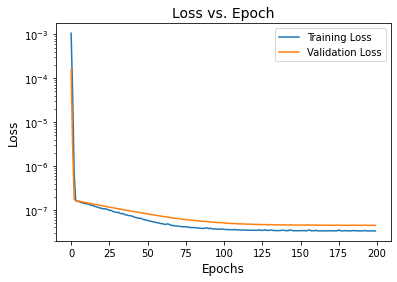

In [ ]:
plotTrain2(train_loss, val_loss, 'Loss', batch_size, lr)

In [ ]:
state_dict = model.state_dict()
torch.save(state_dict, '{}/models/identity_and_bias_clamp.pth'.format(pth))

## Distribution

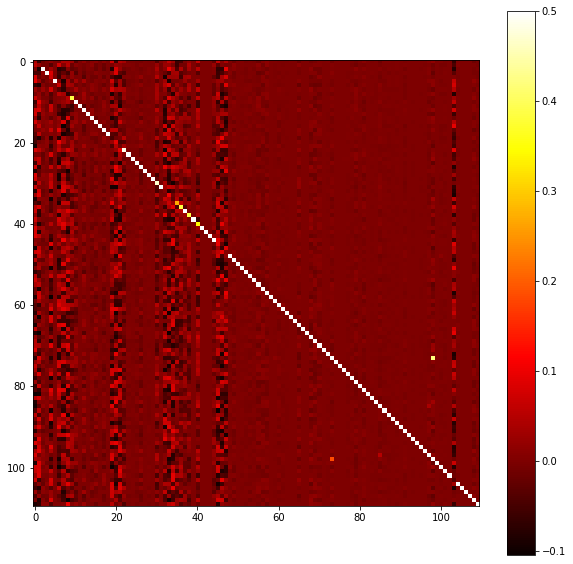

In [11]:
state_dict = torch.load('{}/models/identity/identity_and_bias_clamp.pth'.format(pth))
weights = state_dict['l1.weight'].cpu().detach().numpy()
plt.figure(figsize=(10,10))
plt.imshow(weights, cmap='hot')
plt.colorbar()
plt.savefig('{}/plots/identity/identity_and_bias_clamp.png'.format(pth))
plt.show()

# Identity Layer, no bias + Clamp

## Parameters

In [ ]:
# Training parameters
batch_size = 10000
lr = 0.001
epochs = 200
loss='MSE'

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data

In [ ]:
preds = np.load('{}/data/preds.npy'.format(pth))
# randomized data
samples = preds.shape[0]
random_indices = np.random.choice(preds.shape[0], size=samples, replace=False)
preds = preds[random_indices]

In [ ]:
data_train, data_val, label_train, label_val = train_test_split(preds, preds, test_size=0.3, random_state=421)
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)

## Approximate Layer

In [ ]:
model = identityEsque(bias=False).to(device)
loss_fnc = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# define Clamp constraint
constraints=weightConstraint()

train_loss = []
val_loss = []
start_time = time.time()

for epoch in range(epochs):
    accum_loss = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.type(torch.FloatTensor).to(device)
        labels = labels.type(torch.FloatTensor).to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        batch_loss = loss_fnc(input=outputs, target=labels)
        accum_loss += batch_loss
        batch_loss.backward()
        optimizer.step()

        # Apply Clamp after each update
        model._modules['l1'].apply(constraints)

        del data

    # evaluate per epoch
    _, vloss = evaluate(model, val_loader, loss_fnc, loss, device)
    val_loss.append(vloss)
    train_loss.append(accum_loss.item()/(i+1))

    # print records
    print("Epoch: {} | Train Loss: {:.20f}"
        .format(epoch + 1, train_loss[epoch]))
    print("              Val Loss: {:.20f}"
        .format(val_loss[epoch]))
    accum_loss = 0.0


print('Finished Training')
end_time = time.time()
elapsed_time = end_time - start_time
print("Total training time elapsed: {:.2f} seconds".format(elapsed_time))

Epoch: 1 | Train Loss: 0.00000015810979271515
              Val Loss: 0.00000019978016041478
Epoch: 2 | Train Loss: 0.00000015548496574209
              Val Loss: 0.00000019660197381199
Epoch: 3 | Train Loss: 0.00000015104792004826
              Val Loss: 0.00000019324106403928
Epoch: 4 | Train Loss: 0.00000014666471138803
              Val Loss: 0.00000019007202922694
Epoch: 5 | Train Loss: 0.00000014522434968159
              Val Loss: 0.00000018687164526909
Epoch: 6 | Train Loss: 0.00000013973997031119
              Val Loss: 0.00000018390052503037
Epoch: 7 | Train Loss: 0.00000013746097869848
              Val Loss: 0.00000018086319641952
Epoch: 8 | Train Loss: 0.00000013762041817245
              Val Loss: 0.00000017790883077851
Epoch: 9 | Train Loss: 0.00000013143743318425
              Val Loss: 0.00000017496181214938
Epoch: 10 | Train Loss: 0.00000012744285666284
              Val Loss: 0.00000017216282799382
Epoch: 11 | Train Loss: 0.00000012457529565937
              Val Loss

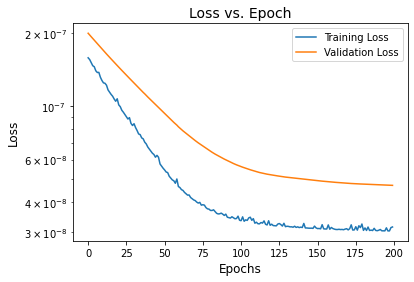

In [ ]:
plotTrain2(train_loss, val_loss, 'Loss', batch_size, lr)

In [ ]:
state_dict = model.state_dict()
torch.save(state_dict, '{}/models/identity_no_bias_clamp.pth'.format(pth))

## Distribution

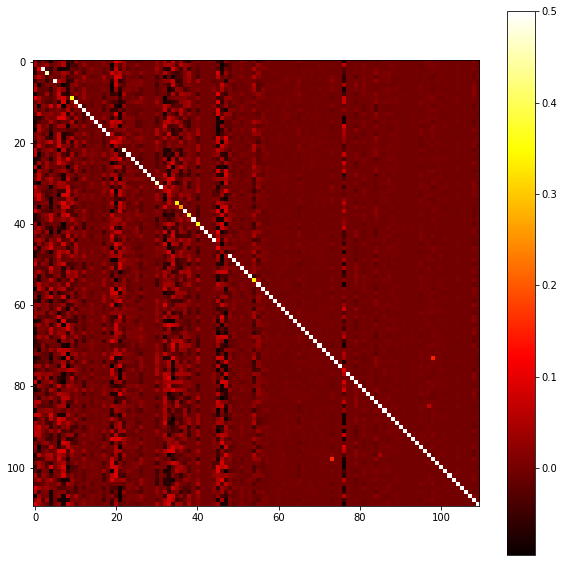

In [12]:
state_dict = torch.load('{}/models/identity/identity_no_bias_clamp.pth'.format(pth))
weights = state_dict['l1.weight'].cpu().detach().numpy()
plt.figure(figsize=(10,10))
plt.imshow(weights, cmap='hot')
plt.colorbar()
plt.savefig('{}/plots/identity/identity_no_bias_clamp.png'.format(pth))
plt.show()

# Identity Layer + Bias + Clamp (10% samples)

## Parameters

In [ ]:
# Training parameters
batch_size = 10000
lr = 0.001
epochs = 200
loss='MSE'

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data

In [ ]:
preds = np.load('{}/data/preds.npy'.format(pth))

# randomized data
samples = preds.shape[0]//10
random_indices = np.random.choice(preds.shape[0], size=samples, replace=False)
preds = preds[random_indices]

In [ ]:
data_train, data_val, label_train, label_val = train_test_split(preds, preds, test_size=0.3, random_state=421)
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)

## Approximate Layer

In [ ]:
model = identityEsque().to(device)
loss_fnc = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# define Clamp constraint
constraints=weightConstraint()

train_loss = []
val_loss = []
start_time = time.time()

for epoch in range(epochs):
    accum_loss = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.type(torch.FloatTensor).to(device)
        labels = labels.type(torch.FloatTensor).to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        batch_loss = loss_fnc(input=outputs, target=labels)
        accum_loss += batch_loss
        batch_loss.backward()
        optimizer.step()

        # Apply Clamp after each update
        model._modules['l1'].apply(constraints)

        del data

    # evaluate per epoch
    _, vloss = evaluate(model, val_loader, loss_fnc, loss, device)
    val_loss.append(vloss)
    train_loss.append(accum_loss.item()/(i+1))

    # print records
    print("Epoch: {} | Train Loss: {:.20f}"
        .format(epoch + 1, train_loss[epoch]))
    print("              Val Loss: {:.20f}"
        .format(val_loss[epoch]))
    accum_loss = 0.0


print('Finished Training')
end_time = time.time()
elapsed_time = end_time - start_time
print("Total training time elapsed: {:.2f} seconds".format(elapsed_time))

Epoch: 1 | Train Loss: 0.00292567280121147633
              Val Loss: 0.00253057572990655899
Epoch: 2 | Train Loss: 0.00226025143638253212
              Val Loss: 0.00193624582607299089
Epoch: 3 | Train Loss: 0.00171856442466378212
              Val Loss: 0.00145972555037587881
Epoch: 4 | Train Loss: 0.00128819490782916546
              Val Loss: 0.00108556868508458138
Epoch: 5 | Train Loss: 0.00095276907086372375
              Val Loss: 0.00079671869752928615
Epoch: 6 | Train Loss: 0.00069541152333840728
              Val Loss: 0.00057692523114383221
Epoch: 7 | Train Loss: 0.00050062686204910278
              Val Loss: 0.00041202735155820847
Epoch: 8 | Train Loss: 0.00035550678148865700
              Val Loss: 0.00029009475838392973
Epoch: 9 | Train Loss: 0.00024868804030120373
              Val Loss: 0.00020127691095694900
Epoch: 10 | Train Loss: 0.00017143129662144929
              Val Loss: 0.00013755013060290366
Epoch: 11 | Train Loss: 0.00011635400005616248
              Val Loss

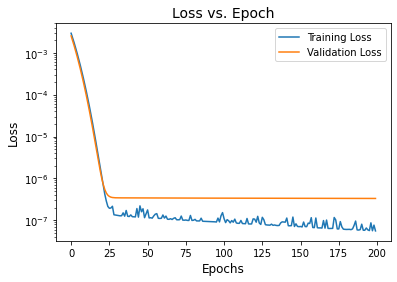

In [ ]:
plotTrain2(train_loss, val_loss, 'Loss', batch_size, lr)

In [ ]:
state_dict = model.state_dict()
torch.save(state_dict, '{}/models/identity_and_bias_clamp_point1.pth'.format(pth))

## Distribution

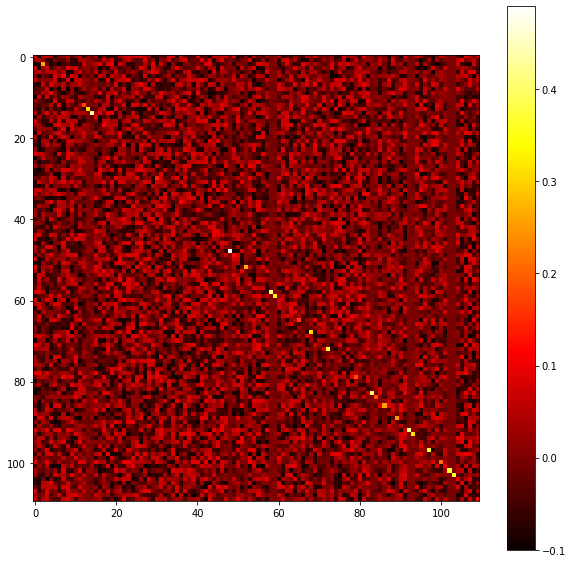

In [13]:
state_dict = torch.load('{}/models/identity/identity_and_bias_clamp_point1.pth'.format(pth))
weights = state_dict['l1.weight'].cpu().detach().numpy()
plt.figure(figsize=(10,10))
plt.imshow(weights, cmap='hot')
plt.colorbar()
plt.savefig('{}/plots/identity/identity_and_bias_clamp_point1.png'.format(pth))
plt.show()

# Identity Layer, no bias + Clamp (10% samples)

## Parameters

In [ ]:
# Training parameters
batch_size = 10000
lr = 0.001
epochs = 200
loss='MSE'

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data

In [ ]:
preds = np.load('{}/data/preds.npy'.format(pth))
# randomized data
samples = preds.shape[0]//10
random_indices = np.random.choice(preds.shape[0], size=samples, replace=False)
preds = preds[random_indices]

In [ ]:
data_train, data_val, label_train, label_val = train_test_split(preds, preds, test_size=0.3, random_state=421)
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)

## Approximate Layer

In [ ]:
model = identityEsque(bias=False).to(device)
loss_fnc = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# define Clamp constraint
constraints=weightConstraint()

train_loss = []
val_loss = []
start_time = time.time()

for epoch in range(epochs):
    accum_loss = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.type(torch.FloatTensor).to(device)
        labels = labels.type(torch.FloatTensor).to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        batch_loss = loss_fnc(input=outputs, target=labels)
        accum_loss += batch_loss
        batch_loss.backward()
        optimizer.step()

        # Apply Clamp after each update
        model._modules['l1'].apply(constraints)

        del data

    # evaluate per epoch
    _, vloss = evaluate(model, val_loader, loss_fnc, loss, device)
    val_loss.append(vloss)
    train_loss.append(accum_loss.item()/(i+1))

    # print records
    print("Epoch: {} | Train Loss: {:.20f}"
        .format(epoch + 1, train_loss[epoch]))
    print("              Val Loss: {:.20f}"
        .format(val_loss[epoch]))
    accum_loss = 0.0


print('Finished Training')
end_time = time.time()
elapsed_time = end_time - start_time
print("Total training time elapsed: {:.2f} seconds".format(elapsed_time))

Epoch: 1 | Train Loss: 0.00000010967048780230
              Val Loss: 0.00000071738185170034
Epoch: 2 | Train Loss: 0.00000011824607781818
              Val Loss: 0.00000071693574454912
Epoch: 3 | Train Loss: 0.00000010803953642835
              Val Loss: 0.00000071657495936961
Epoch: 4 | Train Loss: 0.00000010490998647583
              Val Loss: 0.00000071618973151999
Epoch: 5 | Train Loss: 0.00000013533620801809
              Val Loss: 0.00000071585890282222
Epoch: 6 | Train Loss: 0.00000010336582789705
              Val Loss: 0.00000071545247237736
Epoch: 7 | Train Loss: 0.00000010266894889810
              Val Loss: 0.00000071513306920679
Epoch: 8 | Train Loss: 0.00000014184846008902
              Val Loss: 0.00000071482048724647
Epoch: 9 | Train Loss: 0.00000010143105555471
              Val Loss: 0.00000071448249627792
Epoch: 10 | Train Loss: 0.00000013656453745625
              Val Loss: 0.00000071411119506593
Epoch: 11 | Train Loss: 0.00000010009893003371
              Val Loss

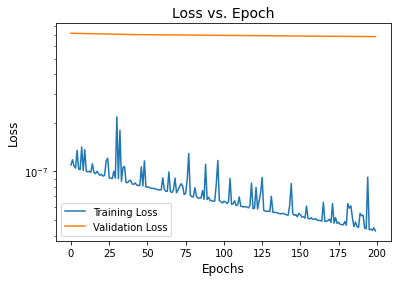

In [ ]:
plotTrain2(train_loss, val_loss, 'Loss', batch_size, lr)

In [ ]:
state_dict = model.state_dict()
torch.save(state_dict, '{}/models/identity_no_bias_clamp_point1.pth'.format(pth))

## Distribution

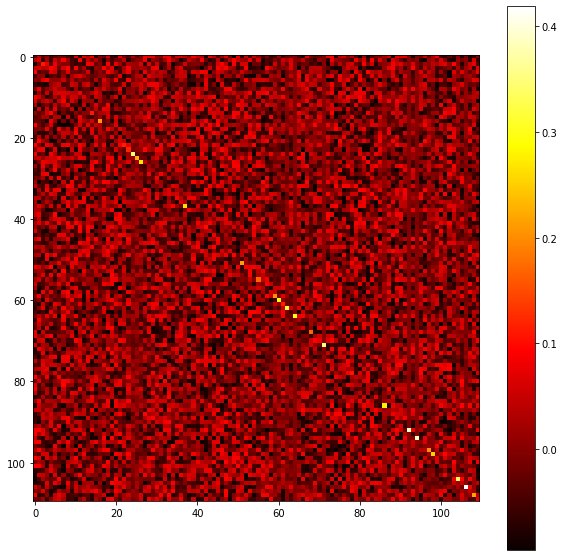

In [14]:
state_dict = torch.load('{}/models/identity/identity_no_bias_clamp_point1.pth'.format(pth))
weights = state_dict['l1.weight'].cpu().detach().numpy()
plt.figure(figsize=(10,10))
plt.imshow(weights, cmap='hot')
plt.colorbar()
plt.savefig('{}/plots/identity/identity_no_bias_clamp_point1.png'.format(pth))
plt.show()

# Identity Layer + Bias + Clamp (5k samples)

## Parameters

In [ ]:
# Training parameters
batch_size = 10000
lr = 0.001
epochs = 200
loss='MSE'

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data

In [ ]:
preds = np.load('{}/data/preds.npy'.format(pth))

# randomized data
samples = 5000
random_indices = np.random.choice(preds.shape[0], size=samples, replace=False)
preds = preds[random_indices]

In [ ]:
data_train, data_val, label_train, label_val = train_test_split(preds, preds, test_size=0.3, random_state=421)
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)

## Approximate Layer

In [ ]:
model = identityEsque().to(device)
loss_fnc = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# define Clamp constraint
constraints=weightConstraint()

train_loss = []
val_loss = []
start_time = time.time()

for epoch in range(epochs):
    accum_loss = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.type(torch.FloatTensor).to(device)
        labels = labels.type(torch.FloatTensor).to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        batch_loss = loss_fnc(input=outputs, target=labels)
        accum_loss += batch_loss
        batch_loss.backward()
        optimizer.step()

        # Apply Clamp after each update
        model._modules['l1'].apply(constraints)

        del data

    # evaluate per epoch
    _, vloss = evaluate(model, val_loader, loss_fnc, loss, device)
    val_loss.append(vloss)
    train_loss.append(accum_loss.item()/(i+1))

    # print records
    print("Epoch: {} | Train Loss: {:.20f}"
        .format(epoch + 1, train_loss[epoch]))
    print("              Val Loss: {:.20f}"
        .format(val_loss[epoch]))
    accum_loss = 0.0


print('Finished Training')
end_time = time.time()
elapsed_time = end_time - start_time
print("Total training time elapsed: {:.2f} seconds".format(elapsed_time))

Epoch: 1 | Train Loss: 0.00289234332740306854
              Val Loss: 0.00279963598586618900
Epoch: 2 | Train Loss: 0.00279973191209137440
              Val Loss: 0.00270907511003315449
Epoch: 3 | Train Loss: 0.00270916754379868507
              Val Loss: 0.00262055778875946999
Epoch: 4 | Train Loss: 0.00262064673006534576
              Val Loss: 0.00253410148434340954
Epoch: 5 | Train Loss: 0.00253418716602027416
              Val Loss: 0.00244972226209938526
Epoch: 6 | Train Loss: 0.00244980514980852604
              Val Loss: 0.00236741942353546619
Epoch: 7 | Train Loss: 0.00236749905161559582
              Val Loss: 0.00228717923164367676
Epoch: 8 | Train Loss: 0.00228725629858672619
              Val Loss: 0.00220898725092411041
Epoch: 9 | Train Loss: 0.00220906175673007965
              Val Loss: 0.00213283114135265350
Epoch: 10 | Train Loss: 0.00213290285319089890
              Val Loss: 0.00205869926139712334
Epoch: 11 | Train Loss: 0.00205876911059021950
              Val Loss

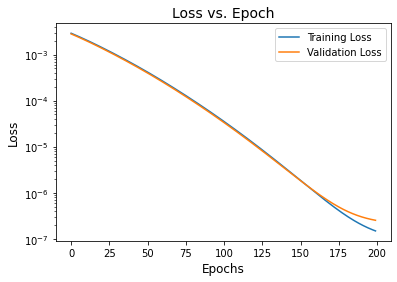

In [ ]:
plotTrain2(train_loss, val_loss, 'Loss', batch_size, lr)

In [ ]:
state_dict = model.state_dict()
torch.save(state_dict, '{}/models/identity_and_bias_clamp_5k.pth'.format(pth))

## Distribution

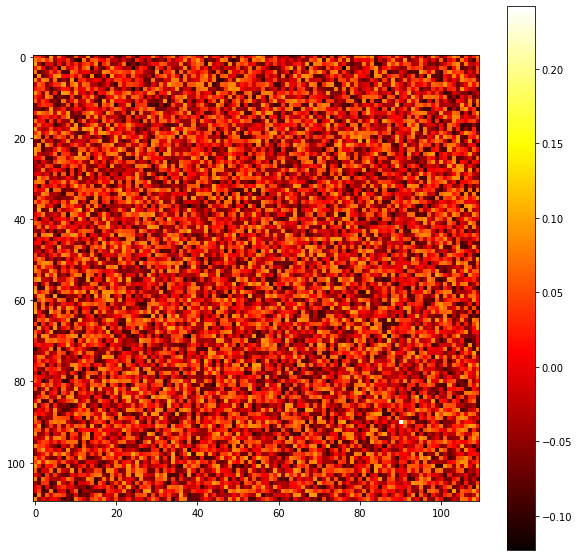

In [15]:
state_dict = torch.load('{}/models/identity/identity_and_bias_clamp_5k.pth'.format(pth))
weights = state_dict['l1.weight'].cpu().detach().numpy()
plt.figure(figsize=(10,10))
plt.imshow(weights, cmap='hot')
plt.colorbar()
plt.savefig('{}/plots/identity/identity_and_bias_clamp_5k.png'.format(pth))
plt.show()

# Identity Layer, no bias + Clamp (5k samples)

## Parameters

In [ ]:
# Training parameters
batch_size = 10000
lr = 0.001
epochs = 200
loss='MSE'

# device for model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data

In [ ]:
preds = np.load('{}/data/preds.npy'.format(pth))
# randomized data
samples = 5000
random_indices = np.random.choice(preds.shape[0], size=samples, replace=False)
preds = preds[random_indices]

In [ ]:
data_train, data_val, label_train, label_val = train_test_split(preds, preds, test_size=0.3, random_state=421)
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)

## Approximate Layer

In [ ]:
model = identityEsque(bias=False).to(device)
loss_fnc = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# define Clamp constraint
constraints=weightConstraint()

train_loss = []
val_loss = []
start_time = time.time()

for epoch in range(epochs):
    accum_loss = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.type(torch.FloatTensor).to(device)
        labels = labels.type(torch.FloatTensor).to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        batch_loss = loss_fnc(input=outputs, target=labels)
        accum_loss += batch_loss
        batch_loss.backward()
        optimizer.step()

        # Apply Clamp after each update
        model._modules['l1'].apply(constraints)

        del data

    # evaluate per epoch
    _, vloss = evaluate(model, val_loader, loss_fnc, loss, device)
    val_loss.append(vloss)
    train_loss.append(accum_loss.item()/(i+1))

    # print records
    print("Epoch: {} | Train Loss: {:.20f}"
        .format(epoch + 1, train_loss[epoch]))
    print("              Val Loss: {:.20f}"
        .format(val_loss[epoch]))
    accum_loss = 0.0


print('Finished Training')
end_time = time.time()
elapsed_time = end_time - start_time
print("Total training time elapsed: {:.2f} seconds".format(elapsed_time))

Epoch: 1 | Train Loss: 0.00000014153989980059
              Val Loss: 0.00000000074920081250
Epoch: 2 | Train Loss: 0.00000014083241239859
              Val Loss: 0.00000000074920042392
Epoch: 3 | Train Loss: 0.00000014013059512763
              Val Loss: 0.00000000074920014637
Epoch: 4 | Train Loss: 0.00000013943449062026
              Val Loss: 0.00000000074919970228
Epoch: 5 | Train Loss: 0.00000013874416993076
              Val Loss: 0.00000000074919931370
Epoch: 6 | Train Loss: 0.00000013805968990255
              Val Loss: 0.00000000074919892512
Epoch: 7 | Train Loss: 0.00000013738102211391
              Val Loss: 0.00000000074919859205
Epoch: 8 | Train Loss: 0.00000013670823761913
              Val Loss: 0.00000000074919820348
Epoch: 9 | Train Loss: 0.00000013604139326162
              Val Loss: 0.00000000074919798143
Epoch: 10 | Train Loss: 0.00000013538051746309
              Val Loss: 0.00000000074919753734
Epoch: 11 | Train Loss: 0.00000013472562443440
              Val Loss

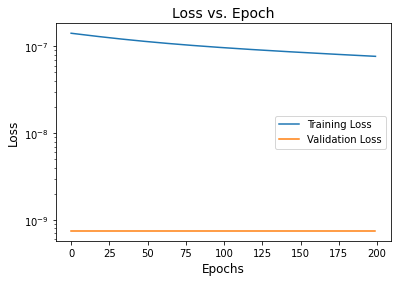

In [ ]:
plotTrain2(train_loss, val_loss, 'Loss', batch_size, lr)

In [ ]:
state_dict = model.state_dict()
torch.save(state_dict, '{}/models/identity_no_bias_clamp_5k.pth'.format(pth))

## Distribution

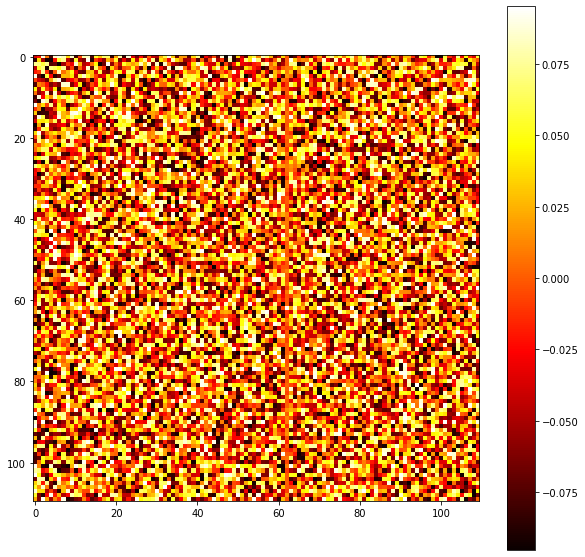

In [16]:
state_dict = torch.load('{}/models/identity/identity_no_bias_clamp_5k.pth'.format(pth))
weights = state_dict['l1.weight'].cpu().detach().numpy()
plt.figure(figsize=(10,10))
plt.imshow(weights, cmap='hot')
plt.colorbar()
plt.savefig('{}/plots/identity/identity_no_bias_clamp_5k.png'.format(pth))
plt.show()